In [2]:
import boto3, gzip, json
import pandas as pd
from io import BytesIO
from datetime import date, timedelta
from botocore import UNSIGNED
from botocore.client import Config

def fetch_ooni_raw(
    country: str,
    test_name: str,
    start_day: str,
    end_day: str,
    max_measurements: int = None,
    verbose: bool = True
):
    """
    Fetch OONI measurements from the public S3 bucket (raw/ structure).
    
    Example S3 layout:
    s3://ooni-data-eu-fra/raw/20220223/15/RU/webconnectivity/2022022315_RU_webconnectivity.n0.0.jsonl.gz
    """
    s3 = boto3.client("s3", region_name="eu-central-1", config=Config(signature_version=UNSIGNED))
    bucket = "ooni-data-eu-fra"
    base_prefix = "raw"

    start = date.fromisoformat(start_day)
    end = date.fromisoformat(end_day)
    records = []
    total_jsonl = 0
    total_tar = 0

    for d in (start + timedelta(n) for n in range((end - start).days + 1)):
        for hour in range(24):
            prefix = f"{base_prefix}/{d.strftime('%Y%m%d')}/{hour:02d}/{country}/{test_name}/"
            if verbose:
                print(f"📦 Listing {prefix} ...")

            paginator = s3.get_paginator("list_objects_v2")
            pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

            for page in pages:
                if "Contents" not in page:
                    continue

                for obj in page["Contents"]:
                    key = obj["Key"]

                    # Skip tar.gz (postcans)
                    if key.endswith(".tar.gz"):
                        total_tar += 1
                        if verbose:
                            print(f"⏭️  Skipping postcan: {key}")
                        continue

                    if not key.endswith(".jsonl.gz"):
                        continue

                    total_jsonl += 1
                    if verbose:
                        print(f"⬇️  Downloading {key} ...")

                    data = s3.get_object(Bucket=bucket, Key=key)["Body"].read()

                    try:
                        with gzip.open(BytesIO(data), "rt", encoding="utf-8") as fh:
                            for line in fh:
                                record = json.loads(line)
                                records.append(record)

                                # Stop early if we hit the max_measurements limit
                                if max_measurements and len(records) >= max_measurements:
                                    if verbose:
                                        print(f"🚫 Reached max_measurements ({max_measurements}), stopping early.")
                                    df = pd.DataFrame(records)
                                    print(f"✅ Loaded {len(records)} measurements "
                                          f"({total_jsonl} JSONL, {total_tar} TAR files skipped)")
                                    return df
                    except Exception as e:
                        print(f"⚠️  Failed to decompress {key}: {e}")

    df = pd.DataFrame(records)
    print(f"✅ Loaded {len(records)} measurements ({total_jsonl} JSONL, {total_tar} TAR files skipped)")
    return df


In [2]:
df = fetch_ooni_raw(
    country="RU",
    test_name="webconnectivity",
    start_day="2022-02-23",
    end_day="2022-02-23",
    max_measurements=5000,  # stop after 5000 lines
)
print(df[["measurement_start_time", "probe_cc", "input"]].head())


📦 Listing raw/20220223/00/RU/webconnectivity/ ...
⬇️  Downloading raw/20220223/00/RU/webconnectivity/2022022300_RU_webconnectivity.n0.0.jsonl.gz ...
⏭️  Skipping postcan: raw/20220223/00/RU/webconnectivity/2022022300_RU_webconnectivity.n0.0.tar.gz
⬇️  Downloading raw/20220223/00/RU/webconnectivity/2022022300_RU_webconnectivity.n0.1.jsonl.gz ...
⏭️  Skipping postcan: raw/20220223/00/RU/webconnectivity/2022022300_RU_webconnectivity.n0.1.tar.gz
⬇️  Downloading raw/20220223/00/RU/webconnectivity/2022022300_RU_webconnectivity.n0.10.jsonl.gz ...
⏭️  Skipping postcan: raw/20220223/00/RU/webconnectivity/2022022300_RU_webconnectivity.n0.10.tar.gz
⬇️  Downloading raw/20220223/00/RU/webconnectivity/2022022300_RU_webconnectivity.n0.11.jsonl.gz ...
⏭️  Skipping postcan: raw/20220223/00/RU/webconnectivity/2022022300_RU_webconnectivity.n0.11.tar.gz
⬇️  Downloading raw/20220223/00/RU/webconnectivity/2022022300_RU_webconnectivity.n0.12.jsonl.gz ...
⏭️  Skipping postcan: raw/20220223/00/RU/webconnectivi

In [3]:
df

,annotations,data_format_version,input,measurement_start_time,probe_asn,probe_cc,probe_ip,probe_network_name,report_id,resolver_asn,resolver_ip,resolver_network_name,software_name,software_version,test_helpers,test_keys,test_name,test_runtime,test_start_time,test_version
0,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,https://top.jdu.ru/,2022-02-22 23:59:44,AS12389,RU,127.0.0.1,PJSC Rostelecom,20220222T235210Z_webconnectivity_RU_12389_n1_C...,AS12389,78.37.77.86,PJSC Rostelecom,ooniprobe-android,3.5.0,{'backend': {'address': 'https://wcth.ooni.io'...,"{'agent': 'redirect', 'client_resolver': '78.3...",web_connectivity,13.854797,2022-02-22 23:52:09,0.4.1
1,"{'architecture': 'arm', 'engine_name': 'oonipr...",0.2.0,http://www.match.com/,2022-02-22 23:59:54,AS31257,RU,127.0.0.1,Orion Telecom LLC,20220222T234931Z_webconnectivity_RU_31257_n1_8...,AS60068,185.76.9.81,Datacamp Limited,ooniprobe-android,3.5.0,{'backend': {'address': 'https://wcth.ooni.io'...,"{'agent': 'redirect', 'client_resolver': '185....",web_connectivity,5.903487,2022-02-22 23:49:31,0.4.1
2,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,https://www.shroomery.org/,2022-02-22 23:59:59,AS12389,RU,127.0.0.1,PJSC Rostelecom,20220222T235210Z_webconnectivity_RU_12389_n1_C...,AS12389,78.37.77.86,PJSC Rostelecom,ooniprobe-android,3.5.0,{'backend': {'address': 'https://wcth.ooni.io'...,"{'agent': 'redirect', 'client_resolver': '78.3...",web_connectivity,2.203999,2022-02-22 23:52:09,0.4.1
3,"{'engine_name': 'ooniprobe-engine', 'engine_ve...",0.2.0,https://www.bnaibrith.org/,2022-02-22 23:59:30,AS25490,RU,127.0.0.1,PJSC Rostelecom,20220222T235807Z_webconnectivity_RU_25490_n1_N...,AS15169,172.217.37.134,Google LLC,ooniprobe-desktop-unattended,3.10.0-beta.3,{'backend': {'address': 'https://wcth.ooni.io'...,"{'agent': 'redirect', 'client_resolver': '172....",web_connectivity,32.222068,2022-02-22 23:58:04,0.4.0
4,"{'engine_name': 'ooniprobe-engine', 'engine_ve...",0.2.0,https://www.dea.gov/index.shtml,2022-02-22 23:59:56,AS8492,RU,127.0.0.1,"""OBIT"" Ltd.",20220222T235325Z_webconnectivity_RU_8492_n1_4D...,AS13335,172.69.9.12,"Cloudflare, Inc.",ooniprobe-desktop-unattended,3.10.0-beta.3,{'backend': {'address': 'https://wcth.ooni.io'...,"{'agent': 'redirect', 'client_resolver': '172....",web_connectivity,6.092541,2022-02-22 23:53:22,0.4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,https://www.wsj.com/,2022-02-23 00:26:11,AS51604,RU,127.0.0.1,"JSC ""ER-Telecom Holding""",20220223T002422Z_webconnectivity_RU_51604_n1_P...,AS6939,216.66.80.90,Hurricane Electric LLC,ooniprobe-android,3.5.0,{'backend': {'address': 'https://wcth.ooni.io'...,"{'agent': 'redirect', 'client_resolver': '216....",web_connectivity,3.037764,2022-02-23 00:24:21,0.4.1
4996,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,http://www.on-instant.com/,2022-02-23 00:26:13,AS34757,RU,127.0.0.1,Sibirskie Seti Ltd.,20220223T000150Z_webconnectivity_RU_34757_n1_D...,AS34757,193.238.131.65,Sibirskie Seti Ltd.,ooniprobe-android,3.5.0,{'backend': {'address': 'https://wcth.ooni.io'...,"{'agent': 'redirect', 'client_resolver': '193....",web_connectivity,1.798442,2022-02-23 00:01:49,0.4.1
4997,"{'engine_name': 'ooniprobe-engine', 'engine_ve...",0.2.0,https://dl.google.com/robots.txt,2022-02-23 00:26:15,AS12389,RU,127.0.0.1,PJSC Rostelecom,20220223T002535Z_webconnectivity_RU_12389_n1_M...,AS12389,212.48.197.66,PJSC Rostelecom,ooniprobe-desktop-unattended,3.10.0-beta.3,{'backend': {'address': 'https://wcth.ooni.io'...,"{'agent': 'redirect', 'client_resolver': '212....",web_connectivity,0.355002,2022-02-23 00:25:35,0.4.0
4998,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,https://search.brave.com/,2022-02-23 00:25:26,AS8402,RU,127.0.0.1,"PJSC ""Vimpelcom""",20220223T002427Z_webconnectivity_RU_8402_n1_ps...,AS15169,172.217.37.135,Google LLC,ooniprobe-android,3.5.0,{'backend': {'address': '

In [4]:
df['test_keys'][0]

{'agent': 'redirect',
 'client_resolver': '78.37.77.86',
 'retries': None,
 'socksproxy': None,
 'network_events': [{'address': '193.0.170.23:443',
   'failure': None,
   'operation': 'connect',
   'proto': 'tcp',
   't': 13.256913539,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'operation': 'tls_handshake_start',
   't': 13.256953924,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 280,
   'operation': 'write',
   't': 13.260765539,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 517,
   'operation': 'read',
   't': 13.285954539,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 3949,
   'operation': 'read',
   't': 13.286219078,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 126,
   'operation': 'write',
   't': 13.303253616,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 51,
   'operation': 'read',
   't': 13.322337309,
   'tags': ['tcptls_experiment']},
 

In [5]:
df.columns

Index(['annotations', 'data_format_version', 'input', 'measurement_start_time',
       'probe_asn', 'probe_cc', 'probe_ip', 'probe_network_name', 'report_id',
       'resolver_asn', 'resolver_ip', 'resolver_network_name', 'software_name',
       'software_version', 'test_helpers', 'test_keys', 'test_name',
       'test_runtime', 'test_start_time', 'test_version'],
      dtype='object')

In [6]:
df['annotations'][10]

{'architecture': 'arm64',
 'engine_name': 'ooniprobe-engine',
 'engine_version': '3.13.0',
 'flavor': 'stableFull',
 'network_type': 'wifi',
 'origin': 'autorun',
 'platform': 'android'}

In [7]:
df['test_keys'][0]

{'agent': 'redirect',
 'client_resolver': '78.37.77.86',
 'retries': None,
 'socksproxy': None,
 'network_events': [{'address': '193.0.170.23:443',
   'failure': None,
   'operation': 'connect',
   'proto': 'tcp',
   't': 13.256913539,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'operation': 'tls_handshake_start',
   't': 13.256953924,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 280,
   'operation': 'write',
   't': 13.260765539,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 517,
   'operation': 'read',
   't': 13.285954539,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 3949,
   'operation': 'read',
   't': 13.286219078,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 126,
   'operation': 'write',
   't': 13.303253616,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 51,
   'operation': 'read',
   't': 13.322337309,
   'tags': ['tcptls_experiment']},
 

In [8]:
df['test_name'][0]

'web_connectivity'

In [9]:
df['resolver_asn'].value_counts()

AS15169    688
AS13335    593
AS12389    538
AS8402     421
AS42       400
AS60068    304
AS42387    299
AS12714    198
AS43966    137
AS31200    118
AS8790     105
AS35807    100
AS21479    100
AS51410    100
AS20485    100
AS34267    100
AS31059    100
AS16276    100
AS25513     93
AS42139     84
AS34757     78
AS56724     72
AS35473     65
AS8359      60
AS6939      42
AS43832      5
Name: resolver_asn, dtype: int64

In [10]:
df['probe_asn'].value_counts()

AS12389    1095
AS8402      518
AS42387     299
AS25513     293
AS8359      260
AS31257     204
AS8334      200
AS12714     198
AS25490     141
AS43966     137
AS44927     129
AS31200     118
AS8790      105
AS35807     100
AS12668     100
AS42610     100
AS29125     100
AS31163     100
AS21479     100
AS51813     100
AS31059     100
AS44724      84
AS34757      78
AS56724      72
AS41691      66
AS25086      65
AS8492       51
AS51604      42
AS41733      40
AS34456       5
Name: probe_asn, dtype: int64

In [11]:
df['resolver_network_name'].value_counts()

PJSC Rostelecom                                                                                 738
Google LLC                                                                                      688
Cloudflare, Inc.                                                                                593
PJSC "Vimpelcom"                                                                                421
WoodyNet                                                                                        400
Datacamp Limited                                                                                304
Limited Company Svyazservice                                                                    299
Net By Net Holding LLC                                                                          198
IT REGION LTD                                                                                   137
MTS PJSC                                                                                        125


In [12]:
df.columns

Index(['annotations', 'data_format_version', 'input', 'measurement_start_time',
       'probe_asn', 'probe_cc', 'probe_ip', 'probe_network_name', 'report_id',
       'resolver_asn', 'resolver_ip', 'resolver_network_name', 'software_name',
       'software_version', 'test_helpers', 'test_keys', 'test_name',
       'test_runtime', 'test_start_time', 'test_version'],
      dtype='object')

In [13]:
df['test_runtime'][1]

5.903487188

In [14]:
df['probe_asn'].value_counts()

AS12389    1095
AS8402      518
AS42387     299
AS25513     293
AS8359      260
AS31257     204
AS8334      200
AS12714     198
AS25490     141
AS43966     137
AS44927     129
AS31200     118
AS8790      105
AS35807     100
AS12668     100
AS42610     100
AS29125     100
AS31163     100
AS21479     100
AS51813     100
AS31059     100
AS44724      84
AS34757      78
AS56724      72
AS41691      66
AS25086      65
AS8492       51
AS51604      42
AS41733      40
AS34456       5
Name: probe_asn, dtype: int64

In [15]:
df[df['probe_asn']=='AS34456']['test_keys'][184]

{'agent': 'redirect',
 'client_resolver': '194.226.75.81',
 'retries': None,
 'socksproxy': None,
 'network_events': [{'address': '172.224.37.10:443',
   'failure': 'connection_refused',
   'operation': 'connect',
   'proto': 'tcp',
   't': 1.560841,
   'tags': ['tcptls_experiment']},
  {'address': '172.224.37.15:443',
   'failure': 'connection_refused',
   'operation': 'connect',
   'proto': 'tcp',
   't': 1.560938,
   'tags': ['tcptls_experiment']},
  {'address': '172.224.37.16:443',
   'failure': 'connection_refused',
   'operation': 'connect',
   'proto': 'tcp',
   't': 1.562028,
   'tags': ['tcptls_experiment']},
  {'address': '172.224.37.17:443',
   'failure': 'connection_refused',
   'operation': 'connect',
   'proto': 'tcp',
   't': 1.61152,
   'tags': ['tcptls_experiment']},
  {'address': '172.224.37.4:443',
   'failure': 'connection_refused',
   'operation': 'connect',
   'proto': 'tcp',
   't': 1.61299,
   'tags': ['tcptls_experiment']},
  {'address': '172.224.37.6:443',
   

In [16]:
df[df['probe_asn']=='AS34456']['test_keys'][177]

{'agent': 'redirect',
 'client_resolver': '194.226.75.81',
 'retries': None,
 'socksproxy': None,
 'network_events': [{'address': '17.248.150.196:443',
   'failure': None,
   'operation': 'connect',
   'proto': 'tcp',
   't': 5.537738,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'operation': 'tls_handshake_start',
   't': 5.537753,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 288,
   'operation': 'write',
   't': 5.538771,
   'tags': ['tcptls_experiment']},
  {'failure': 'eof_error',
   'operation': 'read',
   't': 5.563343,
   'tags': ['tcptls_experiment']},
  {'failure': 'eof_error',
   'operation': 'tls_handshake_done',
   't': 5.56347,
   'tags': ['tcptls_experiment']},
  {'address': '17.248.150.197:443',
   'failure': None,
   'operation': 'connect',
   'proto': 'tcp',
   't': 5.538439,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'operation': 'tls_handshake_start',
   't': 5.538447,
   'tags': ['tcptls_experiment']},
  {'failur

In [17]:
df['test_keys'][10]

{'agent': 'redirect',
 'client_resolver': '5.129.181.74',
 'retries': None,
 'socksproxy': None,
 'network_events': [{'address': '172.67.74.153:443',
   'failure': None,
   'operation': 'connect',
   'proto': 'tcp',
   't': 1.757886666,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'operation': 'tls_handshake_start',
   't': 1.758076093,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 285,
   'operation': 'write',
   't': 1.76242802,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 517,
   'operation': 'read',
   't': 1.82775677,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 2392,
   'operation': 'read',
   't': 1.831352603,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 64,
   'operation': 'write',
   't': 1.838874426,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'operation': 'tls_handshake_done',
   't': 1.839061301,
   'tags': ['tcptls_experiment']},
  {'failure': N

In [18]:
df['software_version'].value_counts()

3.5.0            3237
3.10.0-beta.3    1259
1.0.0             504
Name: software_version, dtype: int64

In [19]:
df[df['software_version']=='3.5.0']['test_keys'][0]

{'agent': 'redirect',
 'client_resolver': '78.37.77.86',
 'retries': None,
 'socksproxy': None,
 'network_events': [{'address': '193.0.170.23:443',
   'failure': None,
   'operation': 'connect',
   'proto': 'tcp',
   't': 13.256913539,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'operation': 'tls_handshake_start',
   't': 13.256953924,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 280,
   'operation': 'write',
   't': 13.260765539,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 517,
   'operation': 'read',
   't': 13.285954539,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 3949,
   'operation': 'read',
   't': 13.286219078,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 126,
   'operation': 'write',
   't': 13.303253616,
   'tags': ['tcptls_experiment']},
  {'failure': None,
   'num_bytes': 51,
   'operation': 'read',
   't': 13.322337309,
   'tags': ['tcptls_experiment']},
 

In [20]:
df[df['software_version']=='3.10.0-beta.3']['test_keys'][3]

{'agent': 'redirect',
 'client_resolver': '172.217.37.134',
 'retries': None,
 'socksproxy': None,
 'network_events': [{'address': '199.34.228.49:443',
   'failure': 'generic_timeout_error',
   'operation': 'connect',
   'proto': 'tcp',
   't': 17.1777439,
   'tags': ['tcptls_experiment']}],
 'tls_handshakes': None,
 'queries': [{'answers': [{'asn': 27647,
     'as_org_name': 'Weebly, Inc.',
     'answer_type': 'A',
     'ipv4': '199.34.228.49',
     'ttl': None}],
   'engine': 'system',
   'failure': None,
   'hostname': 'www.bnaibrith.org',
   'query_type': 'A',
   'resolver_hostname': None,
   'resolver_port': None,
   'resolver_address': '',
   't': 0.1062524}],
 'dns_experiment_failure': None,
 'dns_consistency': 'consistent',
 'control_failure': None,
 'control': {'tcp_connect': {'199.34.228.49:443': {'status': True,
    'failure': None}},
  'http_request': {'body_length': 159268,
   'failure': None,
   'title': "B'nai B'rith International - B'nai B'rith International",
   'heade

In [21]:
df['annotations'].value_counts()

{'architecture': 'arm64', 'engine_name': 'ooniprobe-engine', 'engine_version': '3.13.0', 'flavor': 'stableFull', 'network_type': 'wifi', 'origin': 'autorun', 'platform': 'android'}                                                  2294
{'engine_name': 'ooniprobe-engine', 'engine_version': '3.10.0-beta.3', 'platform': 'windows'}                                                                                                                                          925
{'engine_name': 'ooniprobe-engine', 'engine_version': '3.10.0-beta.3', 'platform': 'linux'}                                                                                                                                            490
{'architecture': 'arm64', 'engine_name': 'ooniprobe-engine', 'engine_version': '3.13.0', 'flavor': 'stableFdroid', 'network_type': 'wifi', 'origin': 'autorun', 'platform': 'android'}                                                 489
{'architecture': 'arm', 'engine_name': 'ooniprobe-engine', '

In [22]:
test={'_probe_engine_sanitize_test_keys': 'true', 'engine_name': 'ooniprobe-engine', 'engine_version': '3.10.0-beta.3', 'platform': 'macos'}

In [23]:
df[df['annotations']==test]

,annotations,data_format_version,input,measurement_start_time,probe_asn,probe_cc,probe_ip,probe_network_name,report_id,resolver_asn,resolver_ip,resolver_network_name,software_name,software_version,test_helpers,test_keys,test_name,test_runtime,test_start_time,test_version
615,"{'_probe_engine_sanitize_test_keys': 'true', '...",0.2.0,http://www.sina.com.cn/,2022-02-23 00:29:59,AS41733,RU,127.0.0.1,"JSC ""ER-Telecom Holding""",20220223T002600Z_webconnectivity_RU_41733_n1_H...,AS15169,173.194.98.7,Google LLC,ooniprobe-desktop-unattended,3.10.0-beta.3,{'backend': {'address': 'https://wcth.ooni.io'...,"{'agent': 'redirect', 'client_resolver': '173....",web_connectivity,1.112522,2022-02-23 00:26:00,0.4.0
635,"{'_probe_engine_sanitize_test_keys': 'true', '...",0.2.0,https://www.queerussia.info/,2022-02-23 00:30:04,AS41733,RU,127.0.0.1,"JSC ""ER-Telecom Holding""",20220223T002600Z_webconnectivity_RU_41733_n1_H...,AS15169,173.194.98.7,Google LLC,ooniprobe-desktop-unattended,3.10.0-beta.3,{'backend': {'address': 'https://wcth.ooni.io'...,"{'agent': 'redirect', 'client_resolver': '173....",web_connectivity,0.493637,2022-02-23 00:26:00,0.4.0
2961,"{'_probe_engine_sanitize_test_keys': 'true', '...",0.2.0,https://ru.m.wikisource.org/,2022-02-23 00:52:58,AS25086,RU,127.0.0.1,MTS PJSC,20220223T004441Z_webconnectivity_RU_25086_n1_2...,AS35473,213.87.74.17,MTS PJSC,ooniprobe-desktop-unattended,3.10.0-beta.3,{'backend': {'address': 'https://wcth.ooni.io'...,"{'agent': 'redirect', 'client_resolver': '213....",web_connectivity,30.972973,2022-02-23 00:44:41,0.4.0


In [71]:
df20 = fetch_ooni_raw(
    country="RU",
    test_name="webconnectivity",
    start_day="2022-02-20",
    end_day="2022-02-20",
    # stop after 5000 lines
)
print(df[["measurement_start_time", "probe_cc", "input"]].head())


📦 Listing raw/20220220/00/RU/webconnectivity/ ...
⬇️  Downloading raw/20220220/00/RU/webconnectivity/2022022000_RU_webconnectivity.n0.0.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/00/RU/webconnectivity/2022022000_RU_webconnectivity.n0.0.tar.gz
⬇️  Downloading raw/20220220/00/RU/webconnectivity/2022022000_RU_webconnectivity.n0.1.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/00/RU/webconnectivity/2022022000_RU_webconnectivity.n0.1.tar.gz
⬇️  Downloading raw/20220220/00/RU/webconnectivity/2022022000_RU_webconnectivity.n0.10.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/00/RU/webconnectivity/2022022000_RU_webconnectivity.n0.10.tar.gz
⬇️  Downloading raw/20220220/00/RU/webconnectivity/2022022000_RU_webconnectivity.n0.11.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/00/RU/webconnectivity/2022022000_RU_webconnectivity.n0.11.tar.gz
⬇️  Downloading raw/20220220/00/RU/webconnectivity/2022022000_RU_webconnectivity.n0.12.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/00/RU/webconnectivi

⏭️  Skipping postcan: raw/20220220/02/RU/webconnectivity/2022022002_RU_webconnectivity.n0.4.tar.gz
⬇️  Downloading raw/20220220/02/RU/webconnectivity/2022022002_RU_webconnectivity.n0.5.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/02/RU/webconnectivity/2022022002_RU_webconnectivity.n0.5.tar.gz
⬇️  Downloading raw/20220220/02/RU/webconnectivity/2022022002_RU_webconnectivity.n0.6.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/02/RU/webconnectivity/2022022002_RU_webconnectivity.n0.6.tar.gz
⬇️  Downloading raw/20220220/02/RU/webconnectivity/2022022002_RU_webconnectivity.n0.7.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/02/RU/webconnectivity/2022022002_RU_webconnectivity.n0.7.tar.gz
⬇️  Downloading raw/20220220/02/RU/webconnectivity/2022022002_RU_webconnectivity.n0.8.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/02/RU/webconnectivity/2022022002_RU_webconnectivity.n0.8.tar.gz
⬇️  Downloading raw/20220220/02/RU/webconnectivity/2022022002_RU_webconnectivity.n0.9.jsonl.gz ...
⏭️  Skippi

⏭️  Skipping postcan: raw/20220220/05/RU/webconnectivity/2022022005_RU_webconnectivity.n0.11.tar.gz
⬇️  Downloading raw/20220220/05/RU/webconnectivity/2022022005_RU_webconnectivity.n0.2.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/05/RU/webconnectivity/2022022005_RU_webconnectivity.n0.2.tar.gz
⬇️  Downloading raw/20220220/05/RU/webconnectivity/2022022005_RU_webconnectivity.n0.3.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/05/RU/webconnectivity/2022022005_RU_webconnectivity.n0.3.tar.gz
⬇️  Downloading raw/20220220/05/RU/webconnectivity/2022022005_RU_webconnectivity.n0.4.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/05/RU/webconnectivity/2022022005_RU_webconnectivity.n0.4.tar.gz
⬇️  Downloading raw/20220220/05/RU/webconnectivity/2022022005_RU_webconnectivity.n0.5.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/05/RU/webconnectivity/2022022005_RU_webconnectivity.n0.5.tar.gz
⬇️  Downloading raw/20220220/05/RU/webconnectivity/2022022005_RU_webconnectivity.n0.6.jsonl.gz ...
⏭️  Skipp

⏭️  Skipping postcan: raw/20220220/07/RU/webconnectivity/2022022007_RU_webconnectivity.n0.6.tar.gz
⬇️  Downloading raw/20220220/07/RU/webconnectivity/2022022007_RU_webconnectivity.n0.7.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/07/RU/webconnectivity/2022022007_RU_webconnectivity.n0.7.tar.gz
⬇️  Downloading raw/20220220/07/RU/webconnectivity/2022022007_RU_webconnectivity.n0.8.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/07/RU/webconnectivity/2022022007_RU_webconnectivity.n0.8.tar.gz
⬇️  Downloading raw/20220220/07/RU/webconnectivity/2022022007_RU_webconnectivity.n0.9.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/07/RU/webconnectivity/2022022007_RU_webconnectivity.n0.9.tar.gz
📦 Listing raw/20220220/08/RU/webconnectivity/ ...
⬇️  Downloading raw/20220220/08/RU/webconnectivity/2022022008_RU_webconnectivity.n0.0.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/08/RU/webconnectivity/2022022008_RU_webconnectivity.n0.0.tar.gz
⬇️  Downloading raw/20220220/08/RU/webconnectivity/20220220

⏭️  Skipping postcan: raw/20220220/09/RU/webconnectivity/2022022009_RU_webconnectivity.n0.7.tar.gz
⬇️  Downloading raw/20220220/09/RU/webconnectivity/2022022009_RU_webconnectivity.n0.8.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/09/RU/webconnectivity/2022022009_RU_webconnectivity.n0.8.tar.gz
⬇️  Downloading raw/20220220/09/RU/webconnectivity/2022022009_RU_webconnectivity.n0.9.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/09/RU/webconnectivity/2022022009_RU_webconnectivity.n0.9.tar.gz
📦 Listing raw/20220220/10/RU/webconnectivity/ ...
⬇️  Downloading raw/20220220/10/RU/webconnectivity/2022022010_RU_webconnectivity.n0.0.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/10/RU/webconnectivity/2022022010_RU_webconnectivity.n0.0.tar.gz
⬇️  Downloading raw/20220220/10/RU/webconnectivity/2022022010_RU_webconnectivity.n0.1.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/10/RU/webconnectivity/2022022010_RU_webconnectivity.n0.1.tar.gz
⬇️  Downloading raw/20220220/10/RU/webconnectivity/20220220

⏭️  Skipping postcan: raw/20220220/11/RU/webconnectivity/2022022011_RU_webconnectivity.n0.6.tar.gz
⬇️  Downloading raw/20220220/11/RU/webconnectivity/2022022011_RU_webconnectivity.n0.7.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/11/RU/webconnectivity/2022022011_RU_webconnectivity.n0.7.tar.gz
⬇️  Downloading raw/20220220/11/RU/webconnectivity/2022022011_RU_webconnectivity.n0.8.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/11/RU/webconnectivity/2022022011_RU_webconnectivity.n0.8.tar.gz
⬇️  Downloading raw/20220220/11/RU/webconnectivity/2022022011_RU_webconnectivity.n0.9.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/11/RU/webconnectivity/2022022011_RU_webconnectivity.n0.9.tar.gz
📦 Listing raw/20220220/12/RU/webconnectivity/ ...
⬇️  Downloading raw/20220220/12/RU/webconnectivity/2022022012_RU_webconnectivity.n0.0.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/12/RU/webconnectivity/2022022012_RU_webconnectivity.n0.0.tar.gz
⬇️  Downloading raw/20220220/12/RU/webconnectivity/20220220

⏭️  Skipping postcan: raw/20220220/13/RU/webconnectivity/2022022013_RU_webconnectivity.n0.7.tar.gz
⬇️  Downloading raw/20220220/13/RU/webconnectivity/2022022013_RU_webconnectivity.n0.8.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/13/RU/webconnectivity/2022022013_RU_webconnectivity.n0.8.tar.gz
⬇️  Downloading raw/20220220/13/RU/webconnectivity/2022022013_RU_webconnectivity.n0.9.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/13/RU/webconnectivity/2022022013_RU_webconnectivity.n0.9.tar.gz
📦 Listing raw/20220220/14/RU/webconnectivity/ ...
⬇️  Downloading raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.0.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.0.tar.gz
⬇️  Downloading raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.1.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.1.tar.gz
⬇️  Downloading raw/20220220/14/RU/webconnectivity/20220220

⏭️  Skipping postcan: raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.43.tar.gz
⬇️  Downloading raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.44.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.44.tar.gz
⬇️  Downloading raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.45.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.45.tar.gz
⬇️  Downloading raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.46.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.46.tar.gz
⬇️  Downloading raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.47.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.47.tar.gz
⬇️  Downloading raw/20220220/14/RU/webconnectivity/2022022014_RU_webconnectivity.n0.48.jsonl.gz ...


⏭️  Skipping postcan: raw/20220220/15/RU/webconnectivity/2022022015_RU_webconnectivity.n0.27.tar.gz
⬇️  Downloading raw/20220220/15/RU/webconnectivity/2022022015_RU_webconnectivity.n0.28.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/15/RU/webconnectivity/2022022015_RU_webconnectivity.n0.28.tar.gz
⬇️  Downloading raw/20220220/15/RU/webconnectivity/2022022015_RU_webconnectivity.n0.29.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/15/RU/webconnectivity/2022022015_RU_webconnectivity.n0.29.tar.gz
⬇️  Downloading raw/20220220/15/RU/webconnectivity/2022022015_RU_webconnectivity.n0.3.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/15/RU/webconnectivity/2022022015_RU_webconnectivity.n0.3.tar.gz
⬇️  Downloading raw/20220220/15/RU/webconnectivity/2022022015_RU_webconnectivity.n0.30.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/15/RU/webconnectivity/2022022015_RU_webconnectivity.n0.30.tar.gz
⬇️  Downloading raw/20220220/15/RU/webconnectivity/2022022015_RU_webconnectivity.n0.31.jsonl.gz ...
⏭️

⏭️  Skipping postcan: raw/20220220/16/RU/webconnectivity/2022022016_RU_webconnectivity.n0.19.tar.gz
⬇️  Downloading raw/20220220/16/RU/webconnectivity/2022022016_RU_webconnectivity.n0.2.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/16/RU/webconnectivity/2022022016_RU_webconnectivity.n0.2.tar.gz
⬇️  Downloading raw/20220220/16/RU/webconnectivity/2022022016_RU_webconnectivity.n0.20.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/16/RU/webconnectivity/2022022016_RU_webconnectivity.n0.20.tar.gz
⬇️  Downloading raw/20220220/16/RU/webconnectivity/2022022016_RU_webconnectivity.n0.3.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/16/RU/webconnectivity/2022022016_RU_webconnectivity.n0.3.tar.gz
⬇️  Downloading raw/20220220/16/RU/webconnectivity/2022022016_RU_webconnectivity.n0.4.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/16/RU/webconnectivity/2022022016_RU_webconnectivity.n0.4.tar.gz
⬇️  Downloading raw/20220220/16/RU/webconnectivity/2022022016_RU_webconnectivity.n0.5.jsonl.gz ...
⏭️  Ski

⏭️  Skipping postcan: raw/20220220/18/RU/webconnectivity/2022022018_RU_webconnectivity.n0.3.tar.gz
⬇️  Downloading raw/20220220/18/RU/webconnectivity/2022022018_RU_webconnectivity.n0.4.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/18/RU/webconnectivity/2022022018_RU_webconnectivity.n0.4.tar.gz
⬇️  Downloading raw/20220220/18/RU/webconnectivity/2022022018_RU_webconnectivity.n0.5.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/18/RU/webconnectivity/2022022018_RU_webconnectivity.n0.5.tar.gz
⬇️  Downloading raw/20220220/18/RU/webconnectivity/2022022018_RU_webconnectivity.n0.6.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/18/RU/webconnectivity/2022022018_RU_webconnectivity.n0.6.tar.gz
⬇️  Downloading raw/20220220/18/RU/webconnectivity/2022022018_RU_webconnectivity.n0.7.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/18/RU/webconnectivity/2022022018_RU_webconnectivity.n0.7.tar.gz
⬇️  Downloading raw/20220220/18/RU/webconnectivity/2022022018_RU_webconnectivity.n0.8.jsonl.gz ...
⏭️  Skippi

⏭️  Skipping postcan: raw/20220220/20/RU/webconnectivity/2022022020_RU_webconnectivity.n0.16.tar.gz
⬇️  Downloading raw/20220220/20/RU/webconnectivity/2022022020_RU_webconnectivity.n0.17.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/20/RU/webconnectivity/2022022020_RU_webconnectivity.n0.17.tar.gz
⬇️  Downloading raw/20220220/20/RU/webconnectivity/2022022020_RU_webconnectivity.n0.18.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/20/RU/webconnectivity/2022022020_RU_webconnectivity.n0.18.tar.gz
⬇️  Downloading raw/20220220/20/RU/webconnectivity/2022022020_RU_webconnectivity.n0.19.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/20/RU/webconnectivity/2022022020_RU_webconnectivity.n0.19.tar.gz
⬇️  Downloading raw/20220220/20/RU/webconnectivity/2022022020_RU_webconnectivity.n0.2.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/20/RU/webconnectivity/2022022020_RU_webconnectivity.n0.2.tar.gz
⬇️  Downloading raw/20220220/20/RU/webconnectivity/2022022020_RU_webconnectivity.n0.20.jsonl.gz ...
⏭️

⏭️  Skipping postcan: raw/20220220/22/RU/webconnectivity/2022022022_RU_webconnectivity.n0.13.tar.gz
⬇️  Downloading raw/20220220/22/RU/webconnectivity/2022022022_RU_webconnectivity.n0.14.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/22/RU/webconnectivity/2022022022_RU_webconnectivity.n0.14.tar.gz
⬇️  Downloading raw/20220220/22/RU/webconnectivity/2022022022_RU_webconnectivity.n0.15.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/22/RU/webconnectivity/2022022022_RU_webconnectivity.n0.15.tar.gz
⬇️  Downloading raw/20220220/22/RU/webconnectivity/2022022022_RU_webconnectivity.n0.16.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/22/RU/webconnectivity/2022022022_RU_webconnectivity.n0.16.tar.gz
⬇️  Downloading raw/20220220/22/RU/webconnectivity/2022022022_RU_webconnectivity.n0.17.jsonl.gz ...
⏭️  Skipping postcan: raw/20220220/22/RU/webconnectivity/2022022022_RU_webconnectivity.n0.17.tar.gz
⬇️  Downloading raw/20220220/22/RU/webconnectivity/2022022022_RU_webconnectivity.n0.18.jsonl.gz ...


In [72]:
df21 = fetch_ooni_raw(
    country="RU",
    test_name="webconnectivity",
    start_day="2022-02-21",
    end_day="2022-02-21",
    # stop after 5000 lines
)

📦 Listing raw/20220221/00/RU/webconnectivity/ ...
⬇️  Downloading raw/20220221/00/RU/webconnectivity/2022022100_RU_webconnectivity.n0.0.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/00/RU/webconnectivity/2022022100_RU_webconnectivity.n0.0.tar.gz
⬇️  Downloading raw/20220221/00/RU/webconnectivity/2022022100_RU_webconnectivity.n0.1.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/00/RU/webconnectivity/2022022100_RU_webconnectivity.n0.1.tar.gz
⬇️  Downloading raw/20220221/00/RU/webconnectivity/2022022100_RU_webconnectivity.n0.10.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/00/RU/webconnectivity/2022022100_RU_webconnectivity.n0.10.tar.gz
⬇️  Downloading raw/20220221/00/RU/webconnectivity/2022022100_RU_webconnectivity.n0.11.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/00/RU/webconnectivity/2022022100_RU_webconnectivity.n0.11.tar.gz
⬇️  Downloading raw/20220221/00/RU/webconnectivity/2022022100_RU_webconnectivity.n0.12.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/00/RU/webconnectivi

⏭️  Skipping postcan: raw/20220221/01/RU/webconnectivity/2022022101_RU_webconnectivity.n0.14.tar.gz
⬇️  Downloading raw/20220221/01/RU/webconnectivity/2022022101_RU_webconnectivity.n0.15.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/01/RU/webconnectivity/2022022101_RU_webconnectivity.n0.15.tar.gz
⬇️  Downloading raw/20220221/01/RU/webconnectivity/2022022101_RU_webconnectivity.n0.16.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/01/RU/webconnectivity/2022022101_RU_webconnectivity.n0.16.tar.gz
⬇️  Downloading raw/20220221/01/RU/webconnectivity/2022022101_RU_webconnectivity.n0.17.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/01/RU/webconnectivity/2022022101_RU_webconnectivity.n0.17.tar.gz
⬇️  Downloading raw/20220221/01/RU/webconnectivity/2022022101_RU_webconnectivity.n0.18.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/01/RU/webconnectivity/2022022101_RU_webconnectivity.n0.18.tar.gz
⬇️  Downloading raw/20220221/01/RU/webconnectivity/2022022101_RU_webconnectivity.n0.19.jsonl.gz ...


⏭️  Skipping postcan: raw/20220221/03/RU/webconnectivity/2022022103_RU_webconnectivity.n0.11.tar.gz
⬇️  Downloading raw/20220221/03/RU/webconnectivity/2022022103_RU_webconnectivity.n0.12.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/03/RU/webconnectivity/2022022103_RU_webconnectivity.n0.12.tar.gz
⬇️  Downloading raw/20220221/03/RU/webconnectivity/2022022103_RU_webconnectivity.n0.13.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/03/RU/webconnectivity/2022022103_RU_webconnectivity.n0.13.tar.gz
⬇️  Downloading raw/20220221/03/RU/webconnectivity/2022022103_RU_webconnectivity.n0.14.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/03/RU/webconnectivity/2022022103_RU_webconnectivity.n0.14.tar.gz
⬇️  Downloading raw/20220221/03/RU/webconnectivity/2022022103_RU_webconnectivity.n0.15.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/03/RU/webconnectivity/2022022103_RU_webconnectivity.n0.15.tar.gz
⬇️  Downloading raw/20220221/03/RU/webconnectivity/2022022103_RU_webconnectivity.n0.16.jsonl.gz ...


⏭️  Skipping postcan: raw/20220221/04/RU/webconnectivity/2022022104_RU_webconnectivity.n0.31.tar.gz
⬇️  Downloading raw/20220221/04/RU/webconnectivity/2022022104_RU_webconnectivity.n0.32.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/04/RU/webconnectivity/2022022104_RU_webconnectivity.n0.32.tar.gz
⬇️  Downloading raw/20220221/04/RU/webconnectivity/2022022104_RU_webconnectivity.n0.33.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/04/RU/webconnectivity/2022022104_RU_webconnectivity.n0.33.tar.gz
⬇️  Downloading raw/20220221/04/RU/webconnectivity/2022022104_RU_webconnectivity.n0.34.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/04/RU/webconnectivity/2022022104_RU_webconnectivity.n0.34.tar.gz
⬇️  Downloading raw/20220221/04/RU/webconnectivity/2022022104_RU_webconnectivity.n0.4.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/04/RU/webconnectivity/2022022104_RU_webconnectivity.n0.4.tar.gz
⬇️  Downloading raw/20220221/04/RU/webconnectivity/2022022104_RU_webconnectivity.n0.5.jsonl.gz ...
⏭️ 

⏭️  Skipping postcan: raw/20220221/05/RU/webconnectivity/2022022105_RU_webconnectivity.n0.37.tar.gz
⬇️  Downloading raw/20220221/05/RU/webconnectivity/2022022105_RU_webconnectivity.n0.38.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/05/RU/webconnectivity/2022022105_RU_webconnectivity.n0.38.tar.gz
⬇️  Downloading raw/20220221/05/RU/webconnectivity/2022022105_RU_webconnectivity.n0.39.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/05/RU/webconnectivity/2022022105_RU_webconnectivity.n0.39.tar.gz
⬇️  Downloading raw/20220221/05/RU/webconnectivity/2022022105_RU_webconnectivity.n0.4.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/05/RU/webconnectivity/2022022105_RU_webconnectivity.n0.4.tar.gz
⬇️  Downloading raw/20220221/05/RU/webconnectivity/2022022105_RU_webconnectivity.n0.40.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/05/RU/webconnectivity/2022022105_RU_webconnectivity.n0.40.tar.gz
⬇️  Downloading raw/20220221/05/RU/webconnectivity/2022022105_RU_webconnectivity.n0.41.jsonl.gz ...
⏭️

⏭️  Skipping postcan: raw/20220221/06/RU/webconnectivity/2022022106_RU_webconnectivity.n0.9.tar.gz
📦 Listing raw/20220221/07/RU/webconnectivity/ ...
⬇️  Downloading raw/20220221/07/RU/webconnectivity/2022022107_RU_webconnectivity.n0.0.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/07/RU/webconnectivity/2022022107_RU_webconnectivity.n0.0.tar.gz
⬇️  Downloading raw/20220221/07/RU/webconnectivity/2022022107_RU_webconnectivity.n0.1.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/07/RU/webconnectivity/2022022107_RU_webconnectivity.n0.1.tar.gz
⬇️  Downloading raw/20220221/07/RU/webconnectivity/2022022107_RU_webconnectivity.n0.10.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/07/RU/webconnectivity/2022022107_RU_webconnectivity.n0.10.tar.gz
⬇️  Downloading raw/20220221/07/RU/webconnectivity/2022022107_RU_webconnectivity.n0.11.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/07/RU/webconnectivity/2022022107_RU_webconnectivity.n0.11.tar.gz
⬇️  Downloading raw/20220221/07/RU/webconnectivity/2022

⏭️  Skipping postcan: raw/20220221/09/RU/webconnectivity/2022022109_RU_webconnectivity.n0.0.tar.gz
⬇️  Downloading raw/20220221/09/RU/webconnectivity/2022022109_RU_webconnectivity.n0.1.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/09/RU/webconnectivity/2022022109_RU_webconnectivity.n0.1.tar.gz
⬇️  Downloading raw/20220221/09/RU/webconnectivity/2022022109_RU_webconnectivity.n0.10.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/09/RU/webconnectivity/2022022109_RU_webconnectivity.n0.10.tar.gz
⬇️  Downloading raw/20220221/09/RU/webconnectivity/2022022109_RU_webconnectivity.n0.11.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/09/RU/webconnectivity/2022022109_RU_webconnectivity.n0.11.tar.gz
⬇️  Downloading raw/20220221/09/RU/webconnectivity/2022022109_RU_webconnectivity.n0.12.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/09/RU/webconnectivity/2022022109_RU_webconnectivity.n0.12.tar.gz
⬇️  Downloading raw/20220221/09/RU/webconnectivity/2022022109_RU_webconnectivity.n0.13.jsonl.gz ...
⏭️ 

⏭️  Skipping postcan: raw/20220221/11/RU/webconnectivity/2022022111_RU_webconnectivity.n0.13.tar.gz
⬇️  Downloading raw/20220221/11/RU/webconnectivity/2022022111_RU_webconnectivity.n0.14.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/11/RU/webconnectivity/2022022111_RU_webconnectivity.n0.14.tar.gz
⬇️  Downloading raw/20220221/11/RU/webconnectivity/2022022111_RU_webconnectivity.n0.2.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/11/RU/webconnectivity/2022022111_RU_webconnectivity.n0.2.tar.gz
⬇️  Downloading raw/20220221/11/RU/webconnectivity/2022022111_RU_webconnectivity.n0.3.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/11/RU/webconnectivity/2022022111_RU_webconnectivity.n0.3.tar.gz
⬇️  Downloading raw/20220221/11/RU/webconnectivity/2022022111_RU_webconnectivity.n0.4.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/11/RU/webconnectivity/2022022111_RU_webconnectivity.n0.4.tar.gz
⬇️  Downloading raw/20220221/11/RU/webconnectivity/2022022111_RU_webconnectivity.n0.5.jsonl.gz ...
⏭️  Ski

⏭️  Skipping postcan: raw/20220221/13/RU/webconnectivity/2022022113_RU_webconnectivity.n0.6.tar.gz
⬇️  Downloading raw/20220221/13/RU/webconnectivity/2022022113_RU_webconnectivity.n0.7.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/13/RU/webconnectivity/2022022113_RU_webconnectivity.n0.7.tar.gz
⬇️  Downloading raw/20220221/13/RU/webconnectivity/2022022113_RU_webconnectivity.n0.8.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/13/RU/webconnectivity/2022022113_RU_webconnectivity.n0.8.tar.gz
⬇️  Downloading raw/20220221/13/RU/webconnectivity/2022022113_RU_webconnectivity.n0.9.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/13/RU/webconnectivity/2022022113_RU_webconnectivity.n0.9.tar.gz
📦 Listing raw/20220221/14/RU/webconnectivity/ ...
⬇️  Downloading raw/20220221/14/RU/webconnectivity/2022022114_RU_webconnectivity.n0.0.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/14/RU/webconnectivity/2022022114_RU_webconnectivity.n0.0.tar.gz
⬇️  Downloading raw/20220221/14/RU/webconnectivity/20220221

⏭️  Skipping postcan: raw/20220221/15/RU/webconnectivity/2022022115_RU_webconnectivity.n0.9.tar.gz
📦 Listing raw/20220221/16/RU/webconnectivity/ ...
⬇️  Downloading raw/20220221/16/RU/webconnectivity/2022022116_RU_webconnectivity.n0.0.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/16/RU/webconnectivity/2022022116_RU_webconnectivity.n0.0.tar.gz
⬇️  Downloading raw/20220221/16/RU/webconnectivity/2022022116_RU_webconnectivity.n0.1.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/16/RU/webconnectivity/2022022116_RU_webconnectivity.n0.1.tar.gz
⬇️  Downloading raw/20220221/16/RU/webconnectivity/2022022116_RU_webconnectivity.n0.10.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/16/RU/webconnectivity/2022022116_RU_webconnectivity.n0.10.tar.gz
⬇️  Downloading raw/20220221/16/RU/webconnectivity/2022022116_RU_webconnectivity.n0.11.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/16/RU/webconnectivity/2022022116_RU_webconnectivity.n0.11.tar.gz
⬇️  Downloading raw/20220221/16/RU/webconnectivity/2022

⏭️  Skipping postcan: raw/20220221/17/RU/webconnectivity/2022022117_RU_webconnectivity.n0.9.tar.gz
📦 Listing raw/20220221/18/RU/webconnectivity/ ...
⬇️  Downloading raw/20220221/18/RU/webconnectivity/2022022118_RU_webconnectivity.n0.0.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/18/RU/webconnectivity/2022022118_RU_webconnectivity.n0.0.tar.gz
⬇️  Downloading raw/20220221/18/RU/webconnectivity/2022022118_RU_webconnectivity.n0.1.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/18/RU/webconnectivity/2022022118_RU_webconnectivity.n0.1.tar.gz
⬇️  Downloading raw/20220221/18/RU/webconnectivity/2022022118_RU_webconnectivity.n0.10.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/18/RU/webconnectivity/2022022118_RU_webconnectivity.n0.10.tar.gz
⬇️  Downloading raw/20220221/18/RU/webconnectivity/2022022118_RU_webconnectivity.n0.11.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/18/RU/webconnectivity/2022022118_RU_webconnectivity.n0.11.tar.gz
⬇️  Downloading raw/20220221/18/RU/webconnectivity/2022

⏭️  Skipping postcan: raw/20220221/19/RU/webconnectivity/2022022119_RU_webconnectivity.n0.25.tar.gz
⬇️  Downloading raw/20220221/19/RU/webconnectivity/2022022119_RU_webconnectivity.n0.26.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/19/RU/webconnectivity/2022022119_RU_webconnectivity.n0.26.tar.gz
⬇️  Downloading raw/20220221/19/RU/webconnectivity/2022022119_RU_webconnectivity.n0.3.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/19/RU/webconnectivity/2022022119_RU_webconnectivity.n0.3.tar.gz
⬇️  Downloading raw/20220221/19/RU/webconnectivity/2022022119_RU_webconnectivity.n0.4.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/19/RU/webconnectivity/2022022119_RU_webconnectivity.n0.4.tar.gz
⬇️  Downloading raw/20220221/19/RU/webconnectivity/2022022119_RU_webconnectivity.n0.5.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/19/RU/webconnectivity/2022022119_RU_webconnectivity.n0.5.tar.gz
⬇️  Downloading raw/20220221/19/RU/webconnectivity/2022022119_RU_webconnectivity.n0.6.jsonl.gz ...
⏭️  Ski

⏭️  Skipping postcan: raw/20220221/21/RU/webconnectivity/2022022121_RU_webconnectivity.n0.15.tar.gz
⬇️  Downloading raw/20220221/21/RU/webconnectivity/2022022121_RU_webconnectivity.n0.16.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/21/RU/webconnectivity/2022022121_RU_webconnectivity.n0.16.tar.gz
⬇️  Downloading raw/20220221/21/RU/webconnectivity/2022022121_RU_webconnectivity.n0.17.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/21/RU/webconnectivity/2022022121_RU_webconnectivity.n0.17.tar.gz
⬇️  Downloading raw/20220221/21/RU/webconnectivity/2022022121_RU_webconnectivity.n0.18.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/21/RU/webconnectivity/2022022121_RU_webconnectivity.n0.18.tar.gz
⬇️  Downloading raw/20220221/21/RU/webconnectivity/2022022121_RU_webconnectivity.n0.19.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/21/RU/webconnectivity/2022022121_RU_webconnectivity.n0.19.tar.gz
⬇️  Downloading raw/20220221/21/RU/webconnectivity/2022022121_RU_webconnectivity.n0.2.jsonl.gz ...
⏭

⏭️  Skipping postcan: raw/20220221/22/RU/webconnectivity/2022022122_RU_webconnectivity.n0.27.tar.gz
⬇️  Downloading raw/20220221/22/RU/webconnectivity/2022022122_RU_webconnectivity.n0.28.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/22/RU/webconnectivity/2022022122_RU_webconnectivity.n0.28.tar.gz
⬇️  Downloading raw/20220221/22/RU/webconnectivity/2022022122_RU_webconnectivity.n0.29.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/22/RU/webconnectivity/2022022122_RU_webconnectivity.n0.29.tar.gz
⬇️  Downloading raw/20220221/22/RU/webconnectivity/2022022122_RU_webconnectivity.n0.3.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/22/RU/webconnectivity/2022022122_RU_webconnectivity.n0.3.tar.gz
⬇️  Downloading raw/20220221/22/RU/webconnectivity/2022022122_RU_webconnectivity.n0.4.jsonl.gz ...
⏭️  Skipping postcan: raw/20220221/22/RU/webconnectivity/2022022122_RU_webconnectivity.n0.4.tar.gz
⬇️  Downloading raw/20220221/22/RU/webconnectivity/2022022122_RU_webconnectivity.n0.5.jsonl.gz ...
⏭️  S

In [73]:
def enrich_time_columns(df, time_col='measurement_start_time'):
    """
    Adds time-related columns to a DataFrame for easier temporal analysis.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing a timestamp column.
        time_col (str): Name of the column containing timestamp strings or datetimes.
    
    Returns:
        pd.DataFrame: DataFrame with added columns:
            - time_of_day
            - seconds_since_midnight
            - date
            - year
            - month
            - day
            - day_of_week
    """
    # Ensure the column is a proper datetime
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

    # Derive components
    df['time_of_day'] = df[time_col].dt.time
    df['seconds_since_midnight'] = (
        df[time_col].dt.hour * 3600 +
        df[time_col].dt.minute * 60 +
        df[time_col].dt.second
    )
    df['date'] = df[time_col].dt.date
    df['year'] = df[time_col].dt.year
    df['month'] = df[time_col].dt.month
    df['day'] = df[time_col].dt.day
    df['day_of_week'] = df[time_col].dt.day_name()

    return df


In [74]:
enrich_time_columns(df20,time_col='measurement_start_time')
enrich_time_columns(df21,time_col='measurement_start_time')

,annotations,data_format_version,input,measurement_start_time,probe_asn,probe_cc,probe_ip,probe_network_name,report_id,resolver_asn,...,input_hashes,probe_city,id,time_of_day,seconds_since_midnight,date,year,month,day,day_of_week
0,"{'architecture': 'arm', 'engine_name': 'oonipr...",0.2.0,https://black.riseup.net/,2022-02-20 23:59:59,AS31257,RU,127.0.0.1,Orion Telecom LLC,20220220T234923Z_webconnectivity_RU_31257_n1_4...,AS60068,...,NaN,NaN,NaN,23:59:59,86399,2022-02-20,2022,2,20,Sunday
1,"{'assets_version': '20210112220115', 'engine_n...",0.2.0,https://exitinternational.net/,2022-02-20 23:59:53,AS15493,RU,127.0.0.1,"""Russian company"" LLC",20220220T231833Z_webconnectivity_RU_15493_n1_o...,AS13335,...,NaN,NaN,NaN,23:59:53,86393,2022-02-20,2022,2,20,Sunday
2,"{'architecture': 'arm', 'engine_name': 'oonipr...",0.2.0,https://pridesource.com/article/top-10-interna...,2022-02-21 00:00:01,AS31257,RU,127.0.0.1,Orion Telecom LLC,20220220T234923Z_webconnectivity_RU_31257_n1_4...,AS60068,...,NaN,NaN,NaN,00:00:01,1,2022-02-21,2022,2,21,Monday
3,"{'assets_version': '20210112220115', 'engine_n...",0.2.0,https://sputnikipogrom.com/,2022-02-21 00:00:02,AS15493,RU,127.0.0.1,"""Russian company"" LLC",20220220T231833Z_webconnectivity_RU_15493_n1_o...,AS13335,...,NaN,NaN,NaN,00:00:02,2,2022-02-21,2022,2,21,Monday
4,"{'_probe_engine_sanitize_test_keys': 'true', '...",0.2.0,http://www.sos-reporters.net/,2022-02-21 00:00:04,AS15493,RU,127.0.0.1,"""Russian company"" LLC",20220220T231833Z_webconnectivity_RU_15493_n1_o...,AS13335,...,NaN,NaN,NaN,00:00:04,4,2022-02-21,2022,2,21,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117740,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,http://www.filesearch.ru/,2022-02-21 23:19:52,AS25513,RU,127.0.0.1,PJSC Moscow city telephone network,20220221T231027Z_webconnectivity_RU_25513_n1_l...,AS42,...,NaN,NaN,NaN,23:19:52,83992,2022-02-21,2022,2,21,Monday
117741,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,http://www.samesexmarriage.ca/,2022-02-21 23:19:51,AS12389,RU,127.0.0.1,PJSC Rostelecom,20220221T231915Z_webconnectivity_RU_12389_n1_7...,AS34267,...,NaN,NaN,NaN,23:19:51,83991,2022-02-21,2022,2,21,Monday
117742,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,http://meddaily.ru/,2022-02-21 23:19:53,AS25513,RU,127.0.0.1,PJSC Moscow city telephone network,20220221T231027Z_webconnectivity_RU_25513_n1_l...,AS42,...,NaN,NaN,NaN,23:19:53,83993,2022-02-21,2022,2,21,Monday
117743,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,https://www.rambler.ru/,2022-02-21 23:19:54,AS12389,RU,127.0.0.1,PJSC Rostelecom,20220221T231949Z_webconnectivity_RU_12389_n1_t...,AS12389,...,NaN,NaN,NaN,23:19:54,83994,2022-02-21,2022,2,21,Monday


In [75]:
df20['seconds_since_midnight']

0         86341
1             7
2             8
3            10
4            11
          ...  
114983    84501
114984    84501
114985    84503
114986    84505
114987    84453
Name: seconds_since_midnight, Length: 114988, dtype: int64

In [76]:
df21['seconds_since_midnight']

0         86399
1         86393
2             1
3             2
4             4
          ...  
117740    83992
117741    83991
117742    83993
117743    83994
117744    83993
Name: seconds_since_midnight, Length: 117745, dtype: int64

In [77]:
import matplotlib.pyplot

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_time_buckets(df, bucket_minutes=10, time_col='seconds_since_midnight'):
    """
    Plot measurement frequency by time-of-day buckets.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing a column of seconds since midnight.
        bucket_minutes (int): Bucket size in minutes (default = 10).
        time_col (str): Column name containing seconds since midnight.
    """
    # Convert bucket size to seconds
    bucket_size = bucket_minutes * 60

    # Create bins for the full 24 hours
    bins = range(0, 86401, bucket_size)
    
    # Generate human-readable labels (e.g., "00:00", "00:10", "00:20", …)
    labels = [
        f"{h:02d}:{m:02d}"
        for h in range(24)
        for m in range(0, 60, bucket_minutes)
    ]

    # Cut the data into labeled bins
    df['time_bucket'] = pd.cut(
        df[time_col],
        bins=bins,
        labels=labels,
        right=False,
        include_lowest=True
    )

    # Count frequency per bucket
    bucket_counts = df['time_bucket'].value_counts().sort_index()

    # Plot
    plt.figure(figsize=(12, 5))
    bucket_counts.plot(kind='bar')
    plt.title(f'Measurement Start Times ({bucket_minutes}-Minute Buckets)')
    plt.xlabel('Time of Day')
    plt.ylabel('Number of Measurements')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return bucket_counts


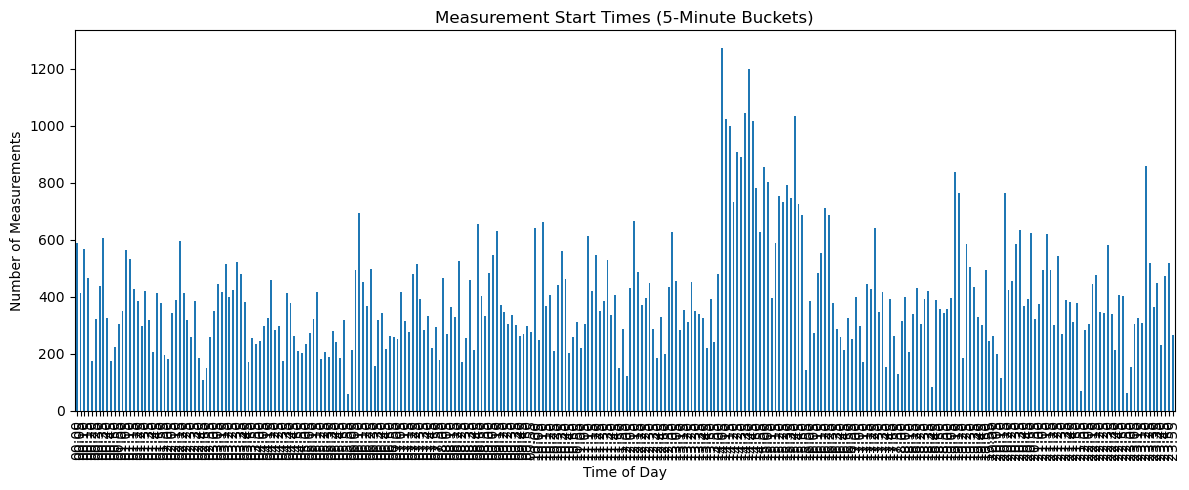

00:00    588
00:05    413
00:10    567
00:15    465
00:20    174
        ... 
23:35    447
23:40    230
23:45    471
23:50    519
23:55    266
Name: time_bucket, Length: 288, dtype: int64

In [81]:
plot_time_buckets(df20, bucket_minutes=5)

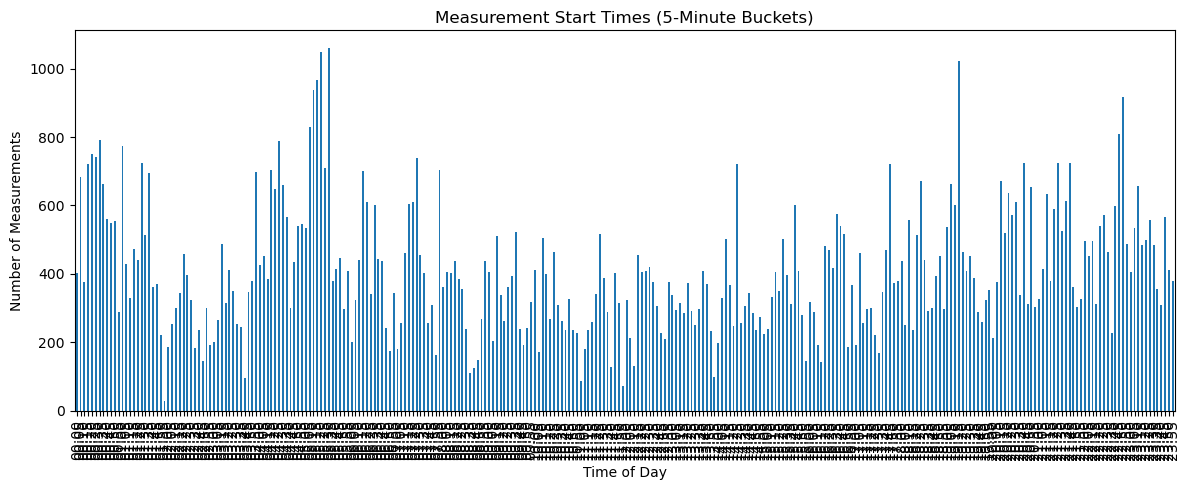

00:00    401
00:05    684
00:10    377
00:15    720
00:20    749
        ... 
23:35    357
23:40    308
23:45    565
23:50    410
23:55    380
Name: time_bucket, Length: 288, dtype: int64

In [82]:
plot_time_buckets(df21, bucket_minutes=5)

In [92]:
type(df21["time_bucket"][0])

str

In [101]:
df21[df21["time_bucket"]=='00:20']

,annotations,data_format_version,input,measurement_start_time,probe_asn,probe_cc,probe_ip,probe_network_name,report_id,resolver_asn,...,probe_city,id,time_of_day,seconds_since_midnight,date,year,month,day,day_of_week,time_bucket
495,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,https://getintra.org/,2022-02-21 00:20:06,AS35807,RU,127.0.0.1,SkyNet Ltd.,20220221T001509Z_webconnectivity_RU_35807_n1_i...,AS35807,...,NaN,NaN,00:20:06,1206,2022-02-21,2022,2,21,Monday,00:20
496,"{'engine_name': 'ooniprobe-engine', 'engine_ve...",0.2.0,https://www.partypoker.net/,2022-02-21 00:20:07,AS8359,RU,127.0.0.1,MTS PJSC,20220221T001630Z_webconnectivity_RU_8359_n1_QQ...,AS8359,...,NaN,NaN,00:20:07,1207,2022-02-21,2022,2,21,Monday,00:20
498,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,https://glazev.ru/,2022-02-21 00:20:07,AS35807,RU,127.0.0.1,SkyNet Ltd.,20220221T001509Z_webconnectivity_RU_35807_n1_i...,AS35807,...,NaN,NaN,00:20:07,1207,2022-02-21,2022,2,21,Monday,00:20
499,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,https://www.7ya.ru/,2022-02-21 00:20:08,AS8402,RU,127.0.0.1,"PJSC ""Vimpelcom""",20220221T001314Z_webconnectivity_RU_8402_n1_t4...,AS15169,...,NaN,NaN,00:20:08,1208,2022-02-21,2022,2,21,Monday,00:20
500,{'platform': 'linux'},0.2.0,http://www.gearthblog.com/,2022-02-21 00:20:07,AS42668,RU,127.0.0.1,NaN,20220221T000031Z_webconnectivity_RU_42668_n1_6...,NaN,...,NaN,f70829ed-02a3-45b1-9931-c7103a1b0427,00:20:07,1207,2022-02-21,2022,2,21,Monday,00:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6974,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,https://vrachirf.ru/,2022-02-21 00:20:06,AS8402,RU,127.0.0.1,"PJSC ""Vimpelcom""",20220221T001314Z_webconnectivity_RU_8402_n1_t4...,AS15169,...,NaN,NaN,00:20:06,1206,2022-02-21,2022,2,21,Monday,00:20
6975,"{'_probe_engine_sanitize_test_keys': 'true', '...",0.2.0,https://www.haaretz.com/life/five-films-you-ha...,2022-02-21 00:20:05,AS8359,RU,127.0.0.1,MTS PJSC,20220221T001630Z_webconnectivity_RU_8359_n1_QQ...,AS8359,...,NaN,NaN,00:20:05,1205,2022-02-21,2022,2,21,Monday,00:20
6976,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,http://www.who.int/topics/family_planning/ru/,2022-02-21 00:20:07,AS8402,RU,127.0.0.1,"PJSC ""Vimpelcom""",20220221T001314Z_webconnectivity_RU_8402_n1_t4...,AS15169,...,NaN,NaN,00:20:07,1207,2022-02-21,2022,2,21,Monday,00:20
6977,"{'architecture': 'arm64', 'engine_name': 'ooni...",0.2.0,http://www.well.com/,2022-02-21 00:20:05,AS35807,RU,127.0.0.1,SkyNet Ltd.,20220221T001509Z_webconnectivity_RU_35807_n1_i...,AS35807,...,NaN,NaN,00:20:05,1205,2022-02-21,2022,2,21,Monday,00:20


In [125]:
df20[(df20["time_bucket"] == "01:30") & (df20["probe_asn"]=='AS25513')]

,annotations,data_format_version,input,measurement_start_time,probe_asn,probe_cc,probe_ip,probe_network_name,report_id,resolver_asn,...,probe_city,id,time_of_day,seconds_since_midnight,date,year,month,day,day_of_week,time_bucket
5246,"{'engine_name': 'ooniprobe-engine', 'engine_ve...",0.2.0,https://messagevortex.net/,2022-02-20 01:34:43,AS25513,RU,127.0.0.1,PJSC Moscow city telephone network,20220220T013535Z_webconnectivity_RU_25513_n1_6...,AS59447,...,NaN,NaN,01:34:43,5683,2022-02-20,2022,2,20,Sunday,01:30


In [128]:
df21[(df21["time_bucket"] == "01:30") & (df21["probe_asn"]=='AS25513')]['annotations']

8540    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8544    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8606    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8613    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8621    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8674    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8752    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8806    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8834    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8847    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8852    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8893    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8943    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8949    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8956    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8962    {'engine_name': 'ooniprobe-engine', 'engine_ve...
8968    {'engine_name': 'ooniprobe-engine', 'engine_ve...
9030    {'engi

In [133]:
df21[(df21["time_bucket"] == "01:30") & (df21["probe_asn"]=='AS25513')]['annotations'][8540]

{'engine_name': 'ooniprobe-engine',
 'engine_version': '3.10.0-beta.3',
 'platform': 'windows'}

In [137]:
df20[(df20["time_bucket"] == "01:30") & (df20["probe_asn"]=='AS25513')]['annotations'][5246]

{'engine_name': 'ooniprobe-engine',
 'engine_version': '3.10.0-beta.3',
 'platform': 'windows'}

In [139]:
df = fetch_ooni_raw(
    country="RU",
    test_name="webconnectivity",
    start_day="2025-02-21",
    end_day="2025-02-21",
    max_measurements=1000
    # stop after 5000 lines
)

📦 Listing raw/20250221/00/RU/webconnectivity/ ...
⬇️  Downloading raw/20250221/00/RU/webconnectivity/2025022100_RU_webconnectivity.n1.0.jsonl.gz ...
🚫 Reached max_measurements (1000), stopping early.
✅ Loaded 1000 measurements (1 JSONL, 0 TAR files skipped)


In [141]:
df['annotations'][0]
#it might be better to look at 2025 or whenever we have more information for annotations

{'architecture': 'arm64',
 'engine_name': 'ooniprobe-engine',
 'engine_version': '3.24.0',
 'flavor': 'ooniStableFull',
 'go_version': 'go1.22.2',
 'network_type': 'wifi',
 'origin': 'autorun',
 'platform': 'android',
 'vcs_modified': '',
 'vcs_revision': '',
 'vcs_time': '',
 'vcs_tool': ''}

In [3]:
df = fetch_ooni_raw(
    country="US",
    test_name="webconnectivity",
    start_day="2025-10-23",
    end_day="2025-02-24",
    # stop after 5000 lines
)

✅ Loaded 0 measurements (0 JSONL, 0 TAR files skipped)
